In [1]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [2]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.6.0
tiktoken version: 0.9.0


In [3]:
import os 

with open("the_verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print("Total number of characters:", len(raw_text))
print(raw_text[:90]) # print first 90 characters

Total number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so i


In [4]:
import re 

text = "Hello World, This is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello', ' ', 'World,', ' ', 'This', ' ', 'is', ' ', 'a', ' ', 'test.']


In [5]:
result = re.split(r'([,.]|\s)',text)
print(result)

['Hello', ' ', 'World', ',', '', ' ', 'This', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


As we can see, this creates empty strings, let's remove them

In [6]:
result = [i for i in result if i.strip()]
print(result)

['Hello', 'World', ',', 'This', 'is', 'a', 'test', '.']


This looks pretty good, but let's also handle other types of punctuation, such as periods, question marks, and so on

In [7]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [8]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


Let's calculate the total number of tokens

In [9]:
print(len(preprocessed))

4690


2.3 Converting tokens into token IDs
Next, we convert the text tokens into token IDs that we can process via embedding layers later

From these tokens, we can now build a vocabulary that consists of all the unique tokens

In [10]:
all_words = sorted(set(preprocessed))# all unique words
vocab_size = len(all_words)
print("Vocabulary size:", vocab_size)

Vocabulary size: 1130


In [11]:
vocab = {token: index for index, token in enumerate(all_words)}
print(type(vocab))

<class 'dict'>


In [12]:
for index, token in enumerate(vocab.items()):
    print(token)
    if index >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [13]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
        
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids 

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # replace spaces before the specified punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- The encode function turns text into token IDs
- The decode function turns token IDs back into text

In [14]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


- We can decode the integers back into text

In [15]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [16]:
tokenizer.decode(tokenizer.encode(text))

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [17]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, world. Is this-- a test?"
tokenizer.encode(text)

KeyError: 'Hello'

- The above produces an error because the word "Hello" is not contained in the vocabulary
- To deal with such cases, we can add special tokens like "<|unk|>" to the vocabulary to represent unknown words
- Since we are already extending the vocabulary, let's add another token called "<|endoftext|>" which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)

In [18]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab= {token: index for index, token in enumerate(all_tokens)}

In [19]:
len(vocab.items())

1132

In [20]:
for index, token in enumerate(list(vocab.items())[-5:]):
    print(token)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


- We also need to adjust the tokenizer accordingly so that it knows when and how to use the new "<unk>" token

In [21]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # replace spaces before the specified punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text



Let's try to tokenize text with the modified tokenizer:

In [22]:
tokenizer = SimpleTokenizerV2(vocab)
text1 = "Hello, world. Is this-- a test?"
text2 = "This is a test of the tokenizer."

text = "<endoftext>".join((text1, text2))
print(text)

Hello, world. Is this-- a test?<endoftext>This is a test of the tokenizer.


In [23]:
tokenizer.encode(text)

[1131,
 5,
 1131,
 7,
 1131,
 999,
 6,
 115,
 1131,
 10,
 1131,
 584,
 115,
 1131,
 722,
 988,
 1131,
 7]

In [24]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, <|unk|>. <|unk|> this -- a <|unk|>? <|unk|> is a <|unk|> of the <|unk|>.'

In [25]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [26]:
tokenizer = tiktoken.get_encoding("gpt2")

In [28]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
        "of someuknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)


[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 2724, 3408, 27271, 13]


In [29]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someuknownPlace.


2.6 Data sampling with a sliding window
- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:


In [30]:
with open("the_verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print("Total number of tokens:", len(enc_text))

Total number of tokens: 5145


- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [31]:
enc_sample = enc_text[50:]

In [32]:
context_size = 4

x = enc_sample[:context_size] # x is the input sequence
y = enc_sample[1:context_size+1] # y is the next token in the sequence

print(f"x: {x}")
print(f"y: {y}")

x: [290, 4920, 2241, 287]
y: [4920, 2241, 287, 257]


- One by one, the prediction would look like as follows:

In [33]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "--->", desired)

[290] ---> 4920
[290, 4920] ---> 2241
[290, 4920, 2241] ---> 287
[290, 4920, 2241, 287] ---> 257


In [34]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


- We will take care of the next-word prediction in a later chapter after we covered the attention mechanism
- For now, we implement a simple data loader that iterates over the input dataset and returns the inputs and targets shifted by one

In [35]:
import torch 
print("pytorch version:", torch.__version__)

c:\Users\nelli\anaconda3\envs\hops\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


pytorch version: 2.6.0+cpu


- We use a sliding window approach, changing the position by +1:

- Create dataset and dataloader that extract chunks from the input text dataset

In [36]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # use a sliding window to chunk the book into overlapping sequences of max_length tokens
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

- tokenizer.encode	Converts text to token IDs
- max_length	How many tokens to consider per training sample
- stride	Step size between windows (controls overlap)
- input_chunk	Model input (e.g., [the, cat, sat])
- target_chunk	Model target (e.g., [cat, sat, on])
- __getitem__	Feeds pairs of input and target to the model

In [38]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         strides=128, shuffle=True, drop_last=True,
                         num_workers=0):
    # initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # create the dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, strides)

    # create the dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

- Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4:

- txt: The full raw input text.

- batch_size: How many samples per batch to return from the DataLoader.

- max_length: Length of each input sequence (context size).

- strides: Step size for sliding window in GPTDatasetV1.

- shuffle: Whether to shuffle the data during loading.

- drop_last: Whether to drop the last incomplete batch.

- num_workers: Number of subprocesses to use for data loading (set to 0 to load in the main process).

In [39]:
with open("the_verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [40]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, strides=1, shuffle=False
)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


raw_text: Your full input text (e.g., from a book or document).

batch_size=1: Return one (input, target) pair per batch — easier to inspect.

max_length=4: Each input sequence is 4 tokens long.

strides=1: Sliding window moves 1 token at a time → maximum overlap.

shuffle=False: So we get batches in order.

drop_last=True by default: It drops the last sample if the batch isn't full (but with batch_size=1, this won’t happen unless the dataset is too small).



In [41]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


An example using stride equal to the context length (here: 4) as shown below:

We can also create batched outputs
Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

In [42]:
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=8,
    max_length=4,
    strides=4,
    shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("inputs:\n", inputs)
print("targets:\n", targets)

inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.7 Creating token embeddings
The data is already almost ready for an LLM
But lastly let us embed the tokens in a continuous vector representation using an embedding layer
Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):

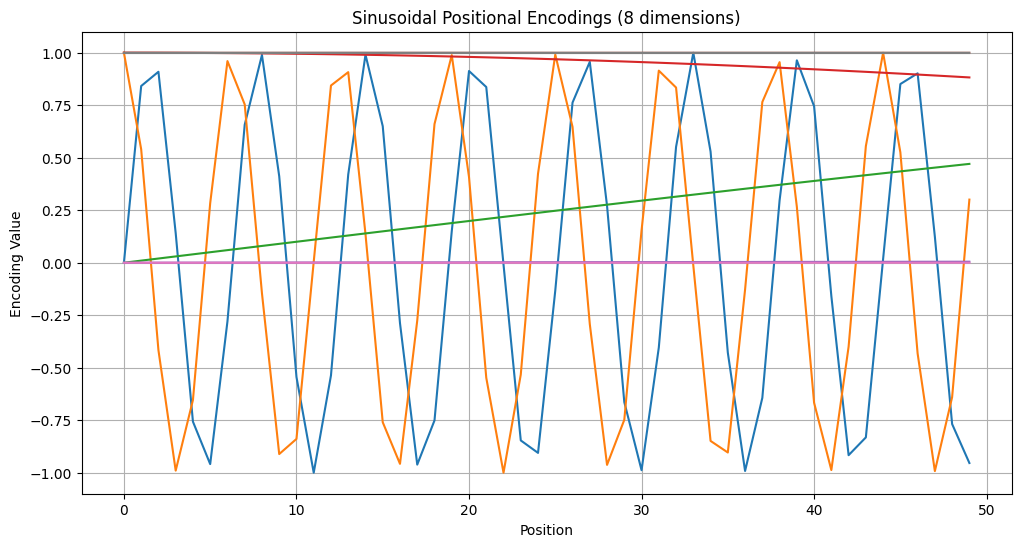

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def get_positional_encoding(max_pos, d_model):
    pe = np.zeros((max_pos, d_model))
    for pos in range(max_pos):
        for i in range(0, d_model, 2):
            pe[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
            if i + 1 < d_model:
                pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i)/d_model)))
    return pe

pe = get_positional_encoding(50, 8)
plt.figure(figsize=(12, 6))
plt.plot(pe)
plt.title("Sinusoidal Positional Encodings (8 dimensions)")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.grid(True)
plt.show()


In [44]:
input_ids = torch.tensor([2, 3, 5, 1])

- For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [45]:
vocab_size = 6
embedding_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim)

- This would result in a 6x3 weight matrix:

In [46]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


“Small vocabulary of 6 words”:

Let's say our vocabulary is:

css
Copy code
["cat", "dog", "sat", "mat", "bat", "rat"]
Each word is assigned a unique index: 0 to 5.

So vocab_size = 6.

“Embeddings of size 3”:

Each word will be represented by a vector of 3 numbers (instead of a one-hot vector).

This vector has real values and is learned during training.

"cat" → [0.25, -0.13, 0.74]


"dog" → [0.63, 0.12, -0.58]


In [47]:
print(embedding_layer(torch.tensor([2])))

tensor([[ 1.2753, -0.2010, -0.1606]], grad_fn=<EmbeddingBackward0>)


In [48]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


- When you pass input_ids into the embedding layer:

- Each index in the input selects a row from the embedding matrix.

- Example: If input_ids = [2, 5, 1, 0], then you're retrieving:

[embedding_layer.weight[2],

 embedding_layer.weight[5],

 embedding_layer.weight[1],
 
 embedding_layer.weight[0]]
 
- So you get a 2D tensor: 4 tokens × 3-dim vector → (4, 3)

| Component                    | Shape    | Meaning                                |
| ---------------------------- | -------- | -------------------------------------- |
| `embedding_layer.weight`     | `(6, 3)` | Full embedding matrix                  |
| `input_ids`                  | `(4,)`   | 4 token indices (integers from 0 to 5) |
| `embedding_layer(input_ids)` | `(4, 3)` | 4 token vectors (looked up by index)   |


## 2.8 Encoding word positions
Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:

The BytePair encoder has a vocabulary size of 50,257:
Suppose we want to encode the input tokens into a 256-dimensional vector representation:

| Feature               | **Absolute Positional Embeddings**                                 | **Relative Positional Embeddings**                                                         |
| --------------------- | ------------------------------------------------------------------ | ------------------------------------------------------------------------------------------ |
| **Focus**             | Position of a token in the sequence (absolute index)               | Distance or offset between tokens in the sequence                                          |
| **Uniqueness**        | Each position has a unique embedding (e.g., sinusoidal or learned) | Embeddings depend on the relationship between tokens                                       |
| **Relationship**      | Does not capture relationship between positions                    | Encodes the **relative distance** between positions                                        |
| **Generalization**    | Can struggle with sequences longer than training data              | More flexible for long-range dependencies                                                  |
| **Example Use Cases** | Tasks like translation or any task where position matters          | Tasks requiring understanding of token interaction (e.g., in long documents, dialog, etc.) |


In [49]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [51]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    strides=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [52]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [53]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


- GPT-2 uses absolute position embeddings, so we just create another embedding layer:

In [55]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
print(pos_embedding_layer.weight.shape)

torch.Size([4, 256])


- To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [57]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings)

tensor([[-0.8194,  0.5543, -0.8290,  ...,  0.1325,  0.2115,  0.3610],
        [ 0.4193, -0.9461, -0.3407,  ...,  0.7930,  1.7009,  0.5663],
        [-0.2362, -1.7187, -1.0489,  ...,  1.1218,  0.2796,  0.9912],
        [-0.9549,  0.4699,  0.2580,  ..., -1.3689,  1.6505,  1.3488]],
       grad_fn=<EmbeddingBackward0>)


In [58]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


In [59]:
print(input_embeddings)

tensor([[[-0.3281,  1.6782,  0.6298,  ..., -0.2670, -1.6620,  0.2165],
         [ 0.8674, -0.6925, -0.6063,  ...,  1.2927,  0.5018, -0.6181],
         [-0.4869, -1.7733, -0.3802,  ...,  2.0836,  2.6533,  0.9384],
         [-0.0091,  1.3356,  1.8771,  ..., -1.8233,  0.9045,  1.6972]],

        [[ 0.7267,  2.2912, -1.6138,  ...,  0.0321,  1.0699,  0.0189],
         [-1.4429, -1.1375, -0.7219,  ...,  1.9150,  1.3513,  1.1754],
         [ 1.7486, -2.3669, -1.1904,  ...,  0.7377, -0.6559,  2.4390],
         [ 0.0099,  1.7672, -1.3627,  ..., -0.2226,  3.2302,  1.7457]],

        [[-1.5907,  1.2115, -0.6627,  ..., -0.6719,  0.2657,  1.1036],
         [ 1.2239, -0.4414,  0.9515,  ...,  2.2578,  2.1106,  0.8868],
         [-0.1567, -3.4823, -0.4740,  ...,  3.3041,  2.1027,  0.6277],
         [-0.5282,  0.4051,  0.8265,  ..., -1.8898,  2.9570,  2.1961]],

        ...,

        [[-2.4349,  1.5153, -3.4727,  ..., -0.8320,  1.3004,  1.9994],
         [ 0.0208, -1.8696, -1.6570,  ..., -0.3652,  0.56